# Final Project - Face emotion detection using Deep Learning
### Course: `CSCN8010-25W-Sec1-Foundations of Machine Learning Frameworks`
### Team - Members:
- **Yun-Chen Wang**     - Student number: 9040873
- **Tai Siang Huang**   - Student number: 9006413
---

## 1. About this presentation:
1. Hands on implement a face emotion dectection webpage using Image segmentation and Image Classification.
2. Try using different network structure to conduct image classification task.
3. Flow chart:
    1. Draw bounding box from a given image.
    2. Identify the emotion by an image classification model.
    3. Display prediction label message above the bounding box.

## 2. Design Architecture

- **Frontend Module**
    - Webpage interface: Based on `Flask` framework, dynamically captures videos from the camera and display prediction results, using Flask framework.
    - Realtime images: `Canvas` component captures real-time image (base64) at 200ms intervals
    - API channel: Sends request to the `app.py` API and expects a response with **face location** and **emotion**

- **Backend Module**
    - Framework: Python `Flask` framework, catches realtime input images from frontend module and return results back.
    - Object detection: Conduct by OpenCV Haar Cascade face detector, that calculates the bounding box of a human face.
    - Emotion identification: Predict emotion type from the input image clipped by bounding box (not the whole image).
    - API channel: Respond to frontend with base64 image format via API

## 3. Showcase demo

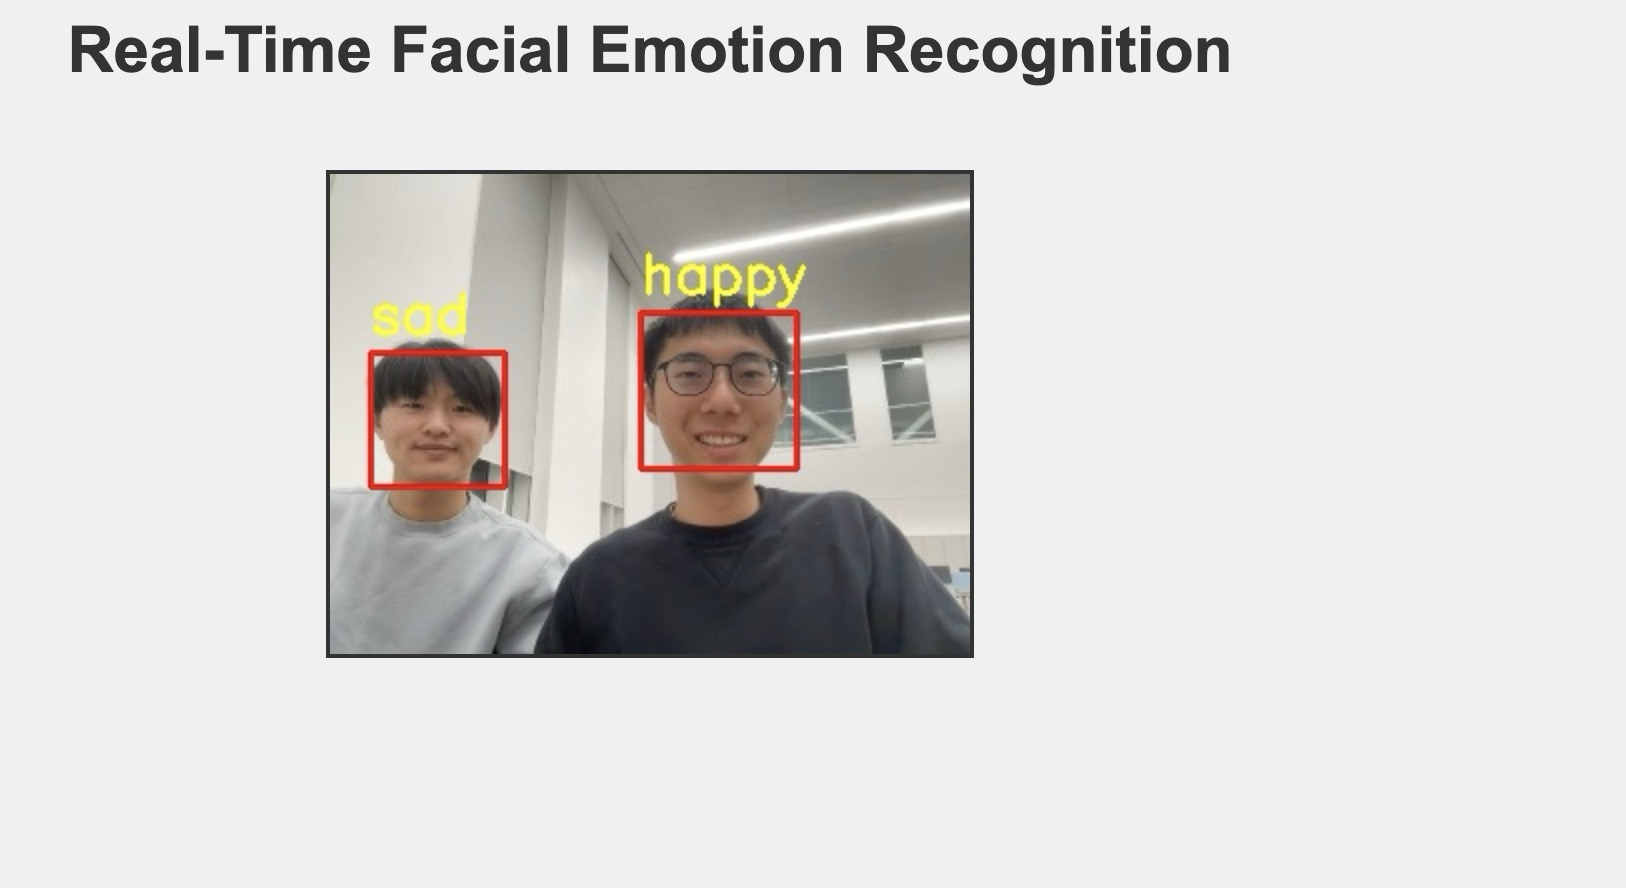

## 4. Image classification

- Envorinment settings

In [ ]:
# For local testing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
# Metrics、Plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(42)
np.random.seed(42)

2025-04-17 00:31:08.777858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744864269.864806   93850 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744864270.141100   93850 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744864272.558502   93850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744864272.558538   93850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744864272.558539   93850 computation_placer.cc:177] computation placer alr

### 4.1 Materials
- **Dataset**
The [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset is selected for model training and evaluation. 
It contains grayscale facial images sized 48x48 pixels. Each face has been automatically aligned so it appears roughly centered and similarly scaled across all images. There are 28,709 images in the training set and 3,589 images in the public test set. The goal of this dataset is to classify the emotion expressed in each face into one of seven categories: 0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, and 6 = Neutral.

- **Research Methods**
We use [ResEmoteNet: Bridging Accuracy and Loss Reduction in Facial Emotion Recognition](https://ieeexplore.ieee.org/document/10812829) to improve our work to identify face emotion, the open source could be found in [Github repo](https://github.com/ArnabKumarRoy02/ResEmoteNet).

- **Image segmentation models**
    - Strategy 1. Builing classification model based on Simple CNN
        - Model 1 CNN basic 4 layer
        - Model 2 Adding Batch Normalization and Dropout
        - Model 3 Adding Batch Normalization with augmentation + SGD + ReduceLROnPlateau
    - Strategy 2. Use pre-trained model MobileNetV2
    - Strategy 3. Using network model ResEmoteNet to improve the performance.

    Note: Strategy 1 and 2 was implemented using Tensorflow, while strategy 3 was built by Pytorch.

### 4.2 Data distribution for each class

angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images


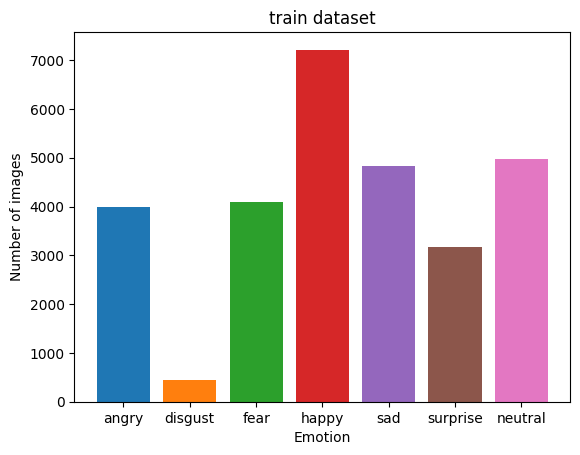

angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
sad: 1247 images
surprise: 831 images
neutral: 1233 images


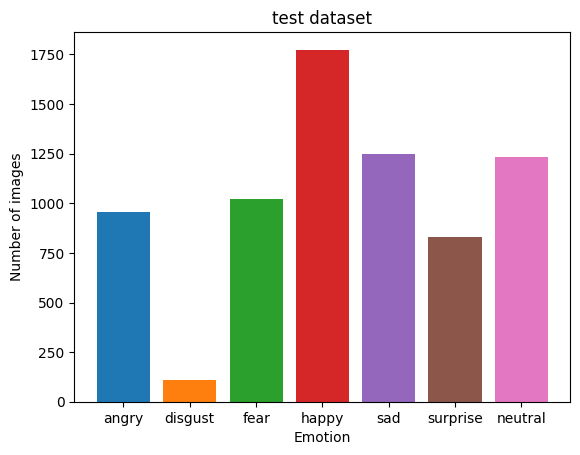

In [ ]:
# plot the histrogram of the dataset
def plot_histogram(data_folder):
    # for each test,train,val folder
    for folder in ['train', 'test']:
        # for each emotion
        for emotion in ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']:
            # get the path of the folder
            path = data_folder / folder / emotion
            # get the number of images in the folder
            num_images = len(list(path.glob('*.jpg')))
            # print the number of images in the folder
            print(f'{emotion}: {num_images} images')
            # plot the histogram
            plt.bar(emotion, num_images)

        plt.title(f'{folder} dataset')
        plt.xlabel('Emotion')
        plt.ylabel('Number of images')
        plt.show()

        
    

plot_histogram(data_folder)

#### Prepare training, validation and testing set. 
(20% of training set will be moved into validation set)

In [ ]:
data_folder = pathlib.Path('./dataset/')

# Load training and validation datasets (split 20% from the train folder as validation set)
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',  # Grayscale images
    image_size=(48, 48),     # FER-2013 image size
    batch_size=32,
    shuffle=True,
    label_mode='categorical',  # Multi-class labels
    validation_split=0.2,     # Split 20% as validation set
    subset="training",        # Select training subset
    seed=42                   # Set random seed for reproducibility
)

val_dataset = image_dataset_from_directory(
    data_folder / "train",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.2,     # Split 20% as validation set
    subset="validation",      # Select validation subset
    seed=42                   # Use the same random seed
)

# Load test dataset (unchanged)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=32,
    shuffle=False,            # No need to shuffle the test set
    label_mode='categorical'
)

# Check class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


I0000 00:00:1744864429.335571   93850 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


- Data normalization

In [ ]:
# Normalize image pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

- Reduce data loading time by caching

In [ ]:
# Optimize data loading
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 4.3 Method 1. Builing classification model based on Simple CNN

- Build model

In [ ]:
# Model 2 CNN with Batch Normalization and Dropout
inputs = keras.Input(shape=(48, 48, 1))

# First block
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Second block
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third block
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Fully connected layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # 7 classes

model_normalization = keras.Model(inputs, outputs)

model_normalization.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_normalization.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

- Training

In [ ]:
# callback to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_model_with_batch_normalization.keras",
        save_best_only=True,
        monitor="val_loss"),
]

# fit the model
history_batch_normalization = model_normalization.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.2724 - loss: 2.1673 - val_accuracy: 0.4616 - val_loss: 1.4036
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4641 - loss: 1.4078 - val_accuracy: 0.4947 - val_loss: 1.3186
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5290 - loss: 1.2392 - val_accuracy: 0.3985 - val_loss: 1.6632
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5539 - loss: 1.1802 - val_accuracy: 0.4820 - val_loss: 1.3519
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5849 - loss: 1.1053 - val_accuracy: 0.5739 - val_loss: 1.1236
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6117 - loss: 1.0319 - val_accuracy: 0.3310 - val_loss: 2.2030
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6134 - loss: 1.0318 - val_accuracy: 0.5781 - val_loss: 1.1399
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6589 - loss: 0.9230 - val_a

- Evaluating the performance.

  1/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5625 - loss: 1.8916

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5858 - loss: 2.2168
Test Loss: 2.0305328369140625
Test Accuracy: 0.6139593124389648
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix (Test Set):
 [[ 541    3   79   66  117  128   24]
 [  29   58    7    3    2    9    3]
 [ 140    1  407   56  142  168  110]
 [  58    2   33 1487  104   54   36]
 [ 124    1   77   99  724  181   27]
 [ 165    1  144   92  255  564   26]
 [  31    1   72   49   34   18  626]]


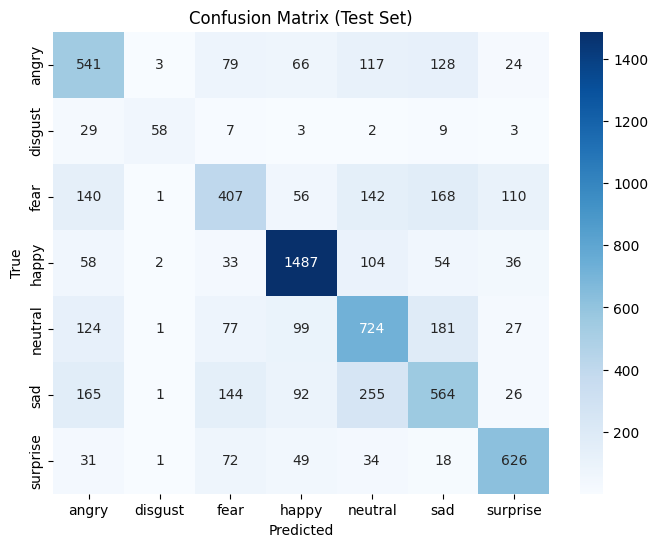

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.50      0.56      0.53       958
     disgust       0.87      0.52      0.65       111
        fear       0.50      0.40      0.44      1024
       happy       0.80      0.84      0.82      1774
     neutral       0.53      0.59      0.55      1233
         sad       0.50      0.45      0.48      1247
    surprise       0.73      0.75      0.74       831

    accuracy                           0.61      7178
   macro avg       0.63      0.59      0.60      7178
weighted avg       0.61      0.61      0.61      7178



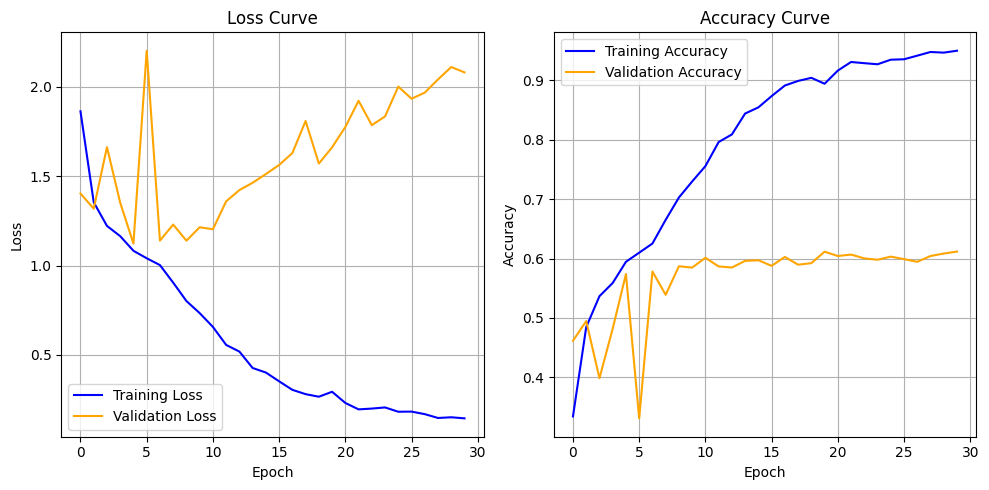

In [ ]:
def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Confusion matrix and classification report (using test_dataset)
    # Get true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Predict labels
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Check if shapes match
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths!")

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (Test Set):\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot training curves (unchanged)
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
# Plot training history
plot_training_history(history_batch_normalization, model_normalization)

**Note**: 
This is unusual. Normally, a model performs better on the training data than on the validation data, so training loss is expected to be lower than validation loss. Maybe the dataset includes some incorrect labels or noise in the training set.

Normalization and Caching

In [ ]:
# Apply transformations
train_dataset = train_dataset.map(grayscale_to_rgb)
val_dataset = val_dataset.map(grayscale_to_rgb)
test_dataset = test_dataset.map(grayscale_to_rgb)

# Normalize image pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])
train_dataset_augmentation = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize data loading
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset_augmentation = train_dataset_augmentation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 4.4 Method 2 - Use pre-train model MobileNetV2

In [ ]:
# Construct MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 model (excluding the top fully connected layers, using pre-trained weights)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
# Freeze the pre-trained layers of MobileNetV2
base_model.trainable = False

# Build the model
inputs = layers.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)  # Use MobileNetV2 for feature extraction
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling to reduce parameter count
x = layers.Dense(256, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)  # Output layer for 7 classes

# Create the model
model_mobilenetv2 = models.Model(inputs, outputs)

# Compile the model (using a smaller learning rate for transfer learning)
model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model structure
model_mobilenetv2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

- Training

In [ ]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./models/best_mobilenet_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

# Train the model
history_mobilenetv2 = model_mobilenetv2.fit(
    train_dataset_augmentation,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1744588875.493504    4595 service.cc:152] XLA service 0x7f77bc001b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744588875.493535    4595 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
I0000 00:00:1744588877.065655    4595 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/718 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.1586 - loss: 3.0234 

I0000 00:00:1744588886.063154    4595 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 75s 85ms/step - accuracy: 0.2606 - loss: 2.0030 - val_accuracy: 0.3566 - val_loss: 1.6388
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3511 - loss: 1.6468 - val_accuracy: 0.3681 - val_loss: 1.6069
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3734 - loss: 1.5971 - val_accuracy: 0.3850 - val_loss: 1.5691
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3941 - loss: 1.5595 - val_accuracy: 0.3954 - val_loss: 1.5570
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4014 - loss: 1.5339 - val_accuracy: 0.3928 - val_loss: 1.5516
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4180 - loss: 1.5066 - val_accuracy: 0.4041 - val_loss: 1.5308
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4252 - loss: 1.4817 - val_accuracy: 0.4048 - val_loss: 1.5226
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4388 - loss: 1.4600 - val_accuracy: 0.4053

- Plotting

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.3689 - loss: 1.5984
Test Loss: 1.4908373355865479
Test Accuracy: 0.42337697744369507
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Confusion Matrix (Test Set):
 [[ 249    0  105  285  171  104   44]
 [  17    0   15   46   18   14    1]
 [ 135    0  232  225  178  129  125]
 [  78    0   68 1317  203   59   49]
 [  93    0  112  324  521  109   74]
 [ 194    0  130  360  271  241   51]
 [  45    0  105   99   84   19  479]]


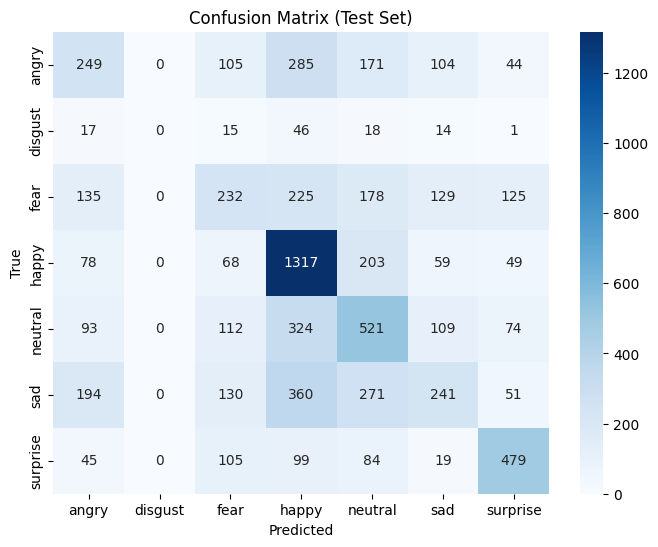

/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/patti/Desktop/Conestoga Courses/ConestogaCollegeWorkplace/venv_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

Classification Report (Test Set):
               precision    recall  f1-score   support

       angry       0.31      0.26      0.28       958
     disgust       0.00      0.00      0.00       111
        fear       0.30      0.23      0.26      1024
       happy       0.50      0.74      0.59      1774
     neutral       0.36      0.42      0.39      1233
         sad       0.36      0.19      0.25      1247
    surprise       0.58      0.58      0.58       831

    accuracy                           0.42      7178
   macro avg       0.34      0.35      0.34      7178
weighted avg       0.40      0.42      0.40      7178



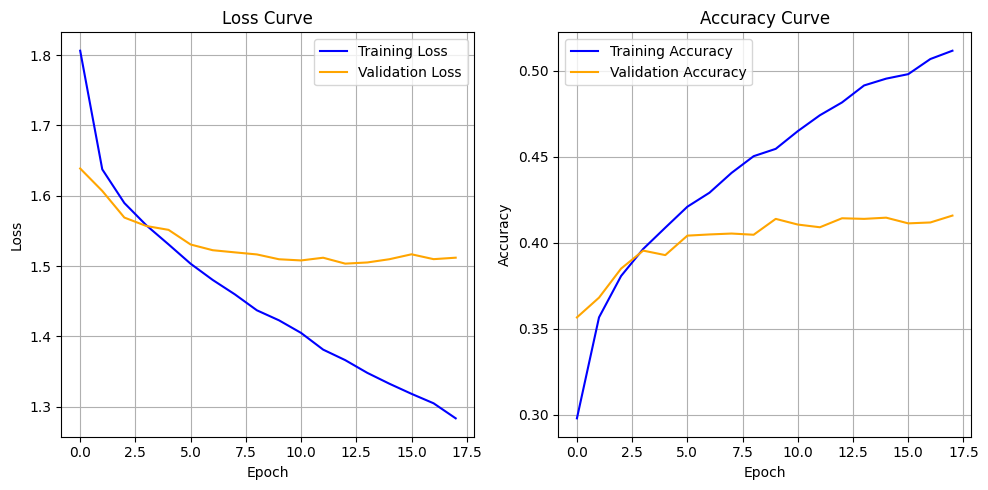

In [ ]:
def plot_training_history(history, model):
    # Final evaluation: Calculate accuracy and loss on the test set
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_acc}")

    # Confusion matrix and classification report (using test_dataset)
    # Get true labels
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)

    # Predict labels
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)

    # Check if shapes match
    if len(y_true) != len(y_pred):
        raise ValueError(f"Mismatch between y_true ({len(y_true)}) and y_pred ({len(y_pred)}) lengths!")

    # Print confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (Test Set):\n", cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("Classification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=class_names))

    # Plot training curves (unchanged)
    plt.figure(figsize=(10, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_mobilenetv2, model_mobilenetv2)

### 4.5 Method 3 - Using ResEmoteNet Without Agumentation

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms
import pathlib

import numpy as np
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import logging
import random

# Set random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)  # If using GPU
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior (reduce randomness)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# Set logging level to show only ERROR level logs
logging.getLogger().setLevel(logging.ERROR)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Clear GPU memory (if previously occupied by other programs)
torch.cuda.empty_cache()

# Set PyTorch memory allocation strategy
torch.cuda.set_per_process_memory_fraction(0.8, device=0)  # Limit GPU memory usage to 80%

from ResEmoteNet.approach.ResEmoteNet import ResEmoteNet


Using device: cuda


In [ ]:
data_folder = pathlib.Path('./dataset/')

- Split into Train, Validation, and Test

In [ ]:
# Load test dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    color_mode='grayscale',
    image_size=(64, 64),
    batch_size=16,
    shuffle=False,
    label_mode='categorical'
)

# Define PyTorch data preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Found 7178 files belonging to 7 classes.


- Convert the TensonFlow data folder to PyTorch formate

In [ ]:
# Custom IterableDataset subclass
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset, transform):
        self.tf_dataset = tf_dataset
        self.transform = transform

    def __iter__(self):
        for images, labels in self.tf_dataset:
            images = images.numpy()
            labels = labels.numpy()
            for i in range(len(images)):
                img = images[i]
                img = self.transform(tf.keras.preprocessing.image.array_to_img(img))
                yield img, labels[i]

# Convert TensorFlow dataset to PyTorch DataLoader
def tf_to_torch(dataset, transform):
    torch_dataset = TFDatasetToTorch(dataset, transform)
    return DataLoader(torch_dataset, batch_size=16)

# Apply transformations
test_loader = tf_to_torch(test_dataset, transform)

# Retrieve class names
class_names = test_dataset.class_names
print("Class names:", class_names)

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


- Normalization and Caching

In [ ]:
# Assume class_names and device are already defined
# Create an instance of the model
model = ResEmoteNet()
model = model.to(device)

# Load pre-trained weights
model_path = "./models/best_model_fer2013_ResEmoteNet.pth"
checkpoint = torch.load(model_path, map_location=device)  # Load the weights file
# state_dict = checkpoint['model_state_dict']  # Extract model_state_dict
model.load_state_dict(checkpoint)  # Load the extracted state_dict
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


Test Accuracy: 53.29%
Confusion Matrix:
 [[ 365    0   51  131  155  216   40]
 [  48    0    9   18   13   22    1]
 [ 121    0  149  115  190  297  152]
 [  58    0   19 1418  160   97   22]
 [  86    0   33  145  702  250   17]
 [ 135    0   57  116  309  601   29]
 [  20    0   51   66   68   36  590]]


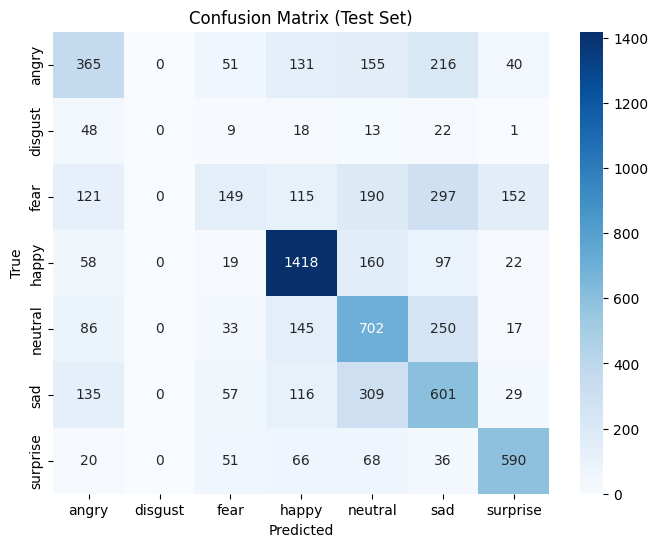

Classification Report:
               precision    recall  f1-score   support

       angry       0.44      0.38      0.41       958
     disgust       0.00      0.00      0.00       111
        fear       0.40      0.15      0.21      1024
       happy       0.71      0.80      0.75      1774
     neutral       0.44      0.57      0.50      1233
         sad       0.40      0.48      0.43      1247
    surprise       0.69      0.71      0.70       831

    accuracy                           0.53      7178
   macro avg       0.44      0.44      0.43      7178
weighted avg       0.52      0.53      0.51      7178



In [ ]:
# Perform inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.argmax(labels, dim=1).to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

### 4.6 Method 4 - Using ResEmoteNet With Agumentation and the Paper's Folder Structure

## 5. Summary

## References:
1. [ResEmoteNet: Bridging Accuracy and Loss Reduction in Facial Emotion Recognition](https://ieeexplore.ieee.org/document/10812829)